In [331]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez
import subprocess
import multiprocessing
import plotly.express as px
import sklearn
from sklearn.decomposition import PCA

In [415]:
dataset = 'external_rna_not_paired'
path = f'DATA/{dataset}/'

In [416]:
data = pd.read_table(f'DATA/{dataset}/result_coverage_table.tsv', index_col=0, converters={'fragments_coverage': pd.eval})

FileNotFoundError: [Errno 2] No such file or directory: 'DATA/external_rna_not_paired/result_coverage_table.tsv'

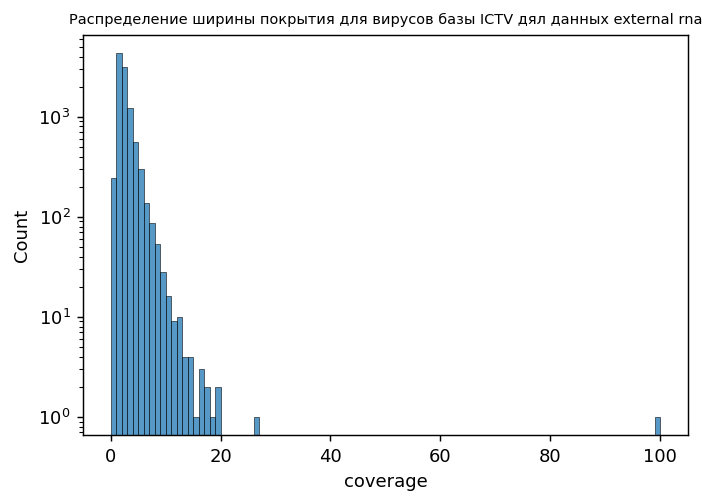

In [241]:
plt.figure(figsize=(6, 4), dpi=130)
plt.title('Распределение ширины покрытия для вирусов базы ICTV дял данных external rna', fontdict={'size':8})
sns.histplot(data.coverage, bins=100)
plt.yscale('log')

Text(0, 0.5, 'Virus names sorted by mean coverage')

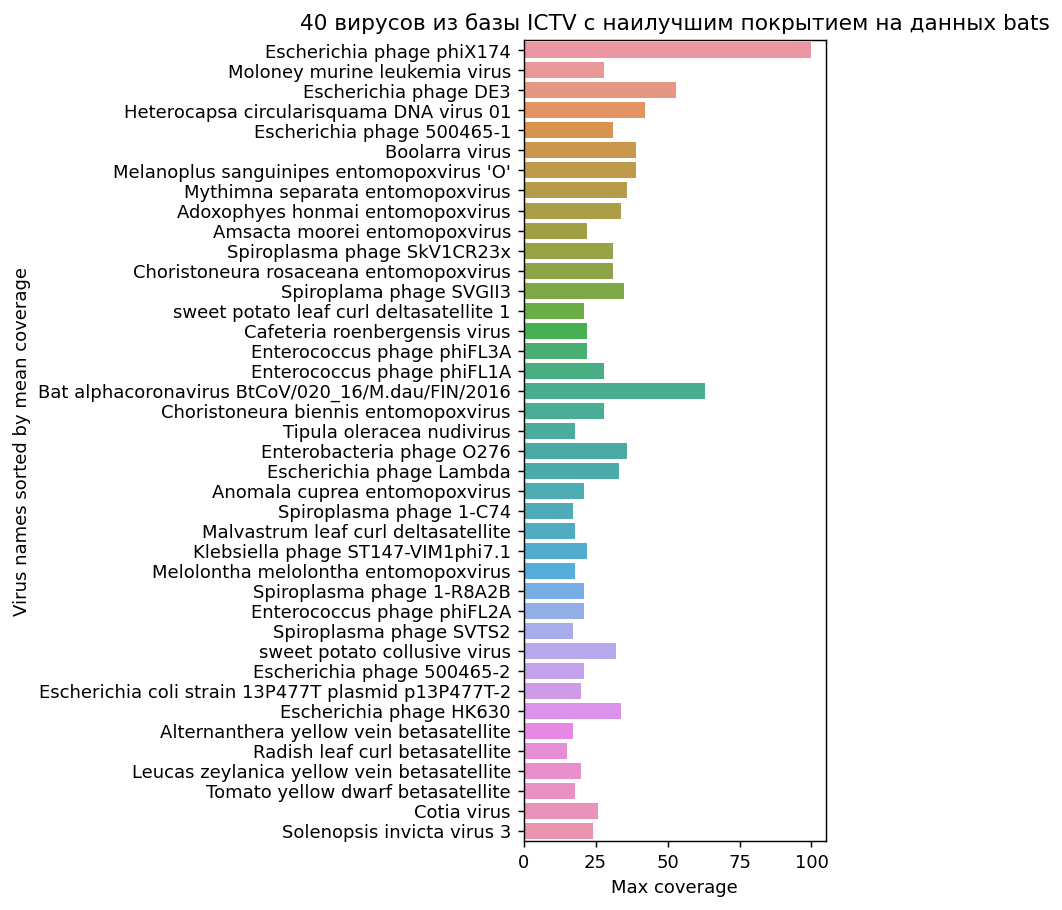

In [242]:
plt.figure(figsize=(3, 8), dpi=130)
plt.title(f'40 вирусов из базы ICTV с наилучшим покрытием на данных {dataset}')
sns.barplot(data=data[:40].sort_values('coverage', ascending=False), x='max_coverage', y='Virus name(s)')
plt.xlabel('Max coverage')
plt.ylabel('Virus names sorted by mean coverage')

In [417]:
ictv_coverages = glob.glob(f'{path}/ictv_coverage/*.csv')

In [451]:
common_table = (pd.DataFrame(pd.read_csv(ictv_coverages[0], index_col=0).coverage).
                rename(columns={'quality':os.path.splitext(os.path.basename(ictv_coverages[0]))[0]}))
for ictv_coverage in ictv_coverages[1:]:
    name = os.path.splitext(os.path.basename(ictv_coverage))[0]
    common_table[name] = pd.DataFrame(pd.read_csv(ictv_coverage, index_col=0).coverage)

/tmp/ipykernel_3867083/284799497.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  common_table[name] = pd.DataFrame(pd.read_csv(ictv_coverage, index_col=0).coverage)
/tmp/ipykernel_3867083/284799497.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  common_table[name] = pd.DataFrame(pd.read_csv(ictv_coverage, index_col=0).coverage)
/tmp/ipykernel_3867083/284799497.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [452]:
means = common_table.max(axis=1)
# sort the rows by the median values
sorted_df = common_table.iloc[means.argsort()[::-1]]

In [464]:
sorted_df[10:30]

,coverage,SRR14360499,SRR12971072,SRR22422953,SRR10020449,SRR14360494,SRR15890995,SRR3956932,SRR12343568,SRR15890975,...,SRR21590392,SRR15058370,SRR15058373,ERR5417951,SRR14360479,SRR15890998,ERR4566030,ERR4566034,SRR15058385,SRR11861909
Species,,,,,,,,,,,,,,,,,,,,,
Phaseolus vulgaris alphaendornavirus 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Harvey murine sarcoma virus,0.389168,0.343029,0.050150,0.270812,0.194584,0.473420,0.048144,0.113340,0.426279,0.100301,...,0.544634,0.098295,0.050150,0.0,0.392177,0.000000,0.323972,0.314945,0.067202,0.000000
Drosophila melanogaster Blastopia virus,0.000000,0.000000,0.000000,0.000000,0.000000,0.014032,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Drosophila melanogaster Roo virus,0.009239,0.017818,0.006929,0.008029,0.005939,0.029257,0.004619,0.005939,0.010229,0.004509,...,0.010669,0.006599,0.000000,0.0,0.009019,0.004399,0.008909,0.010339,0.007699,0.010119
Lambdavirus lambda,0.000000,0.000000,0.003051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.003134,0.000000,0.000000,0.000000,0.000000,0.016391
Pepper mild mottle virus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Escherichia virus DE3,0.001840,0.011578,0.000000,0.000000,0.000000,0.001724,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000745,0.000000,0.000000,0.001771,0.000000,0.002330
Lambdavirus lvO276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.009030,0.000000,0.000000,0.000000,0.000000,0.000000
Hardy-Zuckerman feline sarcoma virus,0.329559,0.302467,0.000000,0.059442,0.200970,0.226041,0.019814,0.000000,0.000000,0.039628,...,0.000000,0.000000,0.000000,0.0,0.263243,0.036797,0.284674,0.174687,0.111605,0.148403


Text(92.13888888888886, 0.5, 'Species sorted by mean quality')

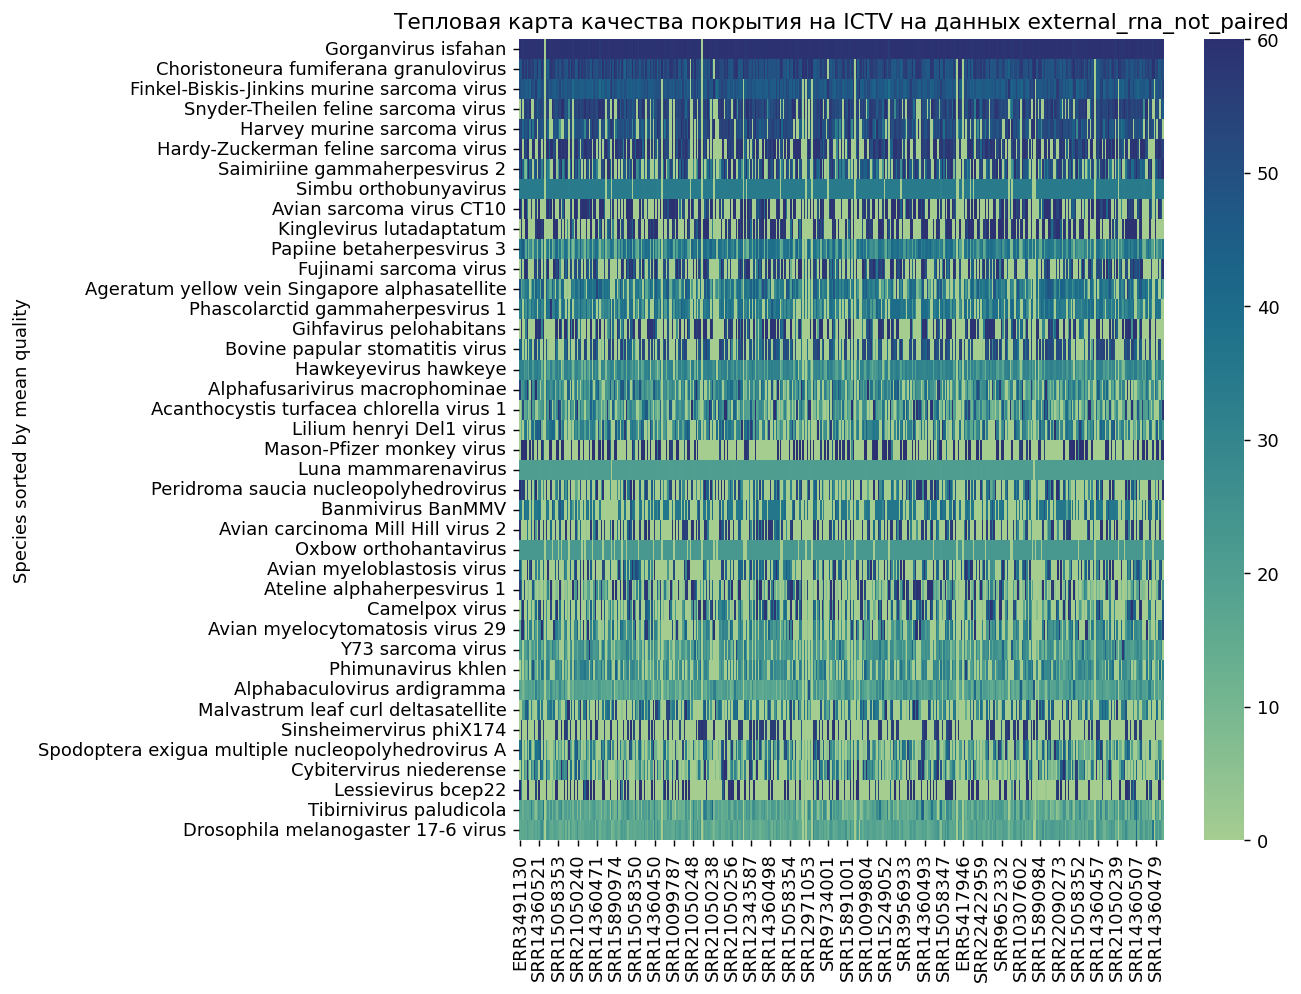

In [439]:
plt.figure(figsize=(8, 8), dpi=130)
sns.heatmap(sorted_df[:40]*100, cmap="crest")
plt.title(f'Тепловая карта качества покрытия на ICTV на данных {dataset}')
plt.ylabel('Species sorted by mean quality')

In [446]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(common_table.T)
X_scaled = scaler.transform(common_table.T)

# оставляем первые две главные компоненты
pca = PCA(n_components=2)
pca.fit(X_scaled)
# преобразуем данные к первым двум главным компонентам
X_pca = pca.transform(X_scaled)
print("Форма исходного массива: {}".format(str(X_scaled.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_pca.shape)))

Форма исходного массива: (435, 10158)
Форма массива после сокращения размерности: (435, 2)


In [449]:
pca.explained_variance_ratio_

array([0.0382657 , 0.03292451])

Text(0.5, 1.0, 'PCA покрытия на ICTV на данных external_rna_not_paired')

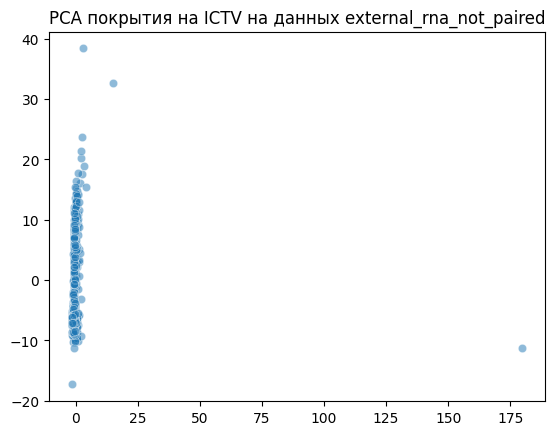

In [447]:

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0.5)
plt.title(f'PCA покрытия на ICTV на данных {dataset}')

In [379]:
comp_frame = pd.DataFrame(pca.components_.T, columns=['PC_1', 'PC_2'], index=common_table.index)

In [385]:
comp_frame = comp_frame.reindex(comp_frame.PC_1.abs().sort_values(ascending=False).index)

<Axes: xlabel='PC_1', ylabel='Species'>

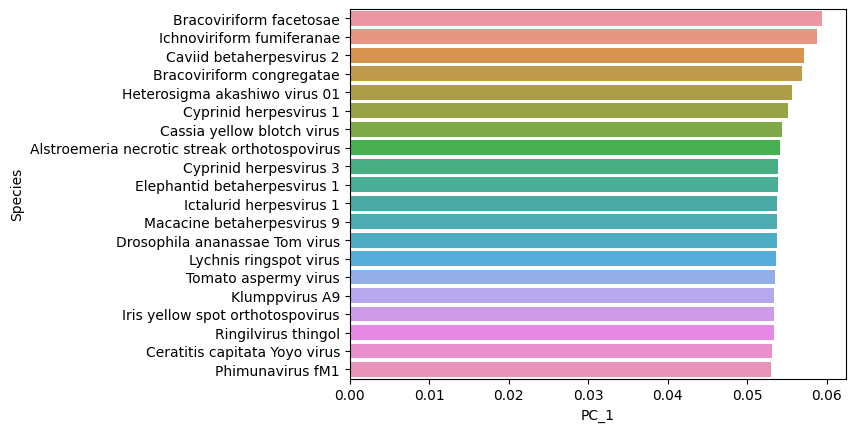

In [387]:
sns.barplot(x=comp_frame.PC_1[:20], y=comp_frame.index[:20])

In [474]:
data = pd.DataFrame(pd.read_csv(f'{path}/ictv_coverage/SRR14360494.csv', index_col=0, converters={'fragments_coverage': pd.eval}))

In [477]:
data[data.fragments_coverage.apply(len) > 0]

,Virus name(s),Host source,coverage,quality,fragments_coverage,Realm,Kingdom,Subkingdom,Phylum,Subphylum,Class,Order,Family,Genus,Species.1,Virus GENBANK accession
Species,,,,,,,,,,,,,,,,
Sinsheimervirus phiX174,Escherichia phage phiX174,bacteria,0.759376,0.561111,[0.759376],Monodnaviria,Sangervirae,NaN,Phixviricota,NaN,Malgrandaviricetes,Petitvirales,Microviridae,Sinsheimervirus,Sinsheimervirus phiX174,J02482
Harvey murine sarcoma virus,Harvey murine sarcoma virus,vertebrates,0.473420,0.513729,[0.47342],Riboviria,Pararnavirae,NaN,Artverviricota,NaN,Revtraviricetes,Ortervirales,Retroviridae,Gammaretrovirus,Harvey murine sarcoma virus,J02207
Drosophila melanogaster copia virus,Drosophila melanogaster copia virus,invertebrates,0.398756,0.512727,[0.398756],Riboviria,Pararnavirae,NaN,Artverviricota,NaN,Revtraviricetes,Ortervirales,Pseudoviridae,Hemivirus,Drosophila melanogaster copia virus,X04456
Finkel-Biskis-Jinkins murine sarcoma virus,Finkel-Biskis-Jinkins murine sarcoma virus,vertebrates,0.237733,0.460602,[0.237733],Riboviria,Pararnavirae,NaN,Artverviricota,NaN,Revtraviricetes,Ortervirales,Retroviridae,Gammaretrovirus,Finkel-Biskis-Jinkins murine sarcoma virus,K02712
Snyder-Theilen feline sarcoma virus,Snyder-Theilen feline sarcoma virus,vertebrates,0.231789,0.524957,[0.231789],Riboviria,Pararnavirae,NaN,Artverviricota,NaN,Revtraviricetes,Ortervirales,Retroviridae,Gammaretrovirus,Snyder-Theilen feline sarcoma virus,M22820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gammahypovirus meridionalis,Sclerotium rolfsii hypovirus 5 strain BLH-1-20,fungi,0.000000,0.000000,[0.0],Riboviria,Orthornavirae,NaN,Pisuviricota,NaN,Duplopiviricetes,Durnavirales,Hypoviridae,Gammahypovirus,Gammahypovirus meridionalis,MH766500
Gammahypovirus sclerotii,Sclerotium rolfsii hypovirus 2 strain BLH-1-17,fungi,0.000000,0.000000,[0.0],Riboviria,Orthornavirae,NaN,Pisuviricota,NaN,Duplopiviricetes,Durnavirales,Hypoviridae,Gammahypovirus,Gammahypovirus sclerotii,MH766497
Gammahypovirus sinensis,Sclerotium rolfsii hypovirus 3 strain BLH-18,fungi,0.000000,0.000000,[0.0],Riboviria,Orthornavirae,NaN,Pisuviricota,NaN,Duplopiviricetes,Durnavirales,Hypoviridae,Gammahypovirus,Gammahypovirus sinensis,MH766498
